# Pruebas con el encoder MiniLM

In [11]:
!pip install hdbscan
!pip install umap-learn
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296190 sha256=bc544cf3efba0bd8f4dbfe06103f63e53175addb0536ad7d166fbbcb853e4336
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [2]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import nltk
import time

from matplotlib.colors import ListedColormap
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler


# Escalar embeddings

nltk.download("stopwords")
nltk.download("wordnet")

# Cargar un modelo multilingüe, adecuado para español
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
'''
Pasa todo a minusculas
remueve urls: No util
remueve signos de puntuacion: Para simplicidad de la gestion de palabras
remueve los tags (@username): No util
remueve las stopwords: No aportan mucho valor para nuestros modelos en NLP
lematiza los datos, es decir, los pone en su forma base: Para favorecer el procesamiento de los datos
remueve espacios de mas: Logico, dado que solo generan mas ruido en nuestro texto

Esta funcion es similar a la mostrada en clase, pero reestructura con expresiones
regulares para mayor simplicidad y orden

'''
lemmatizer = WordNetLemmatizer()
def preprocess_string(input_string):
  input_string = input_string.lower()
  input_string = re.sub(r"@\w+", '', input_string)
  input_string = re.sub(r"http\S+|www\S+|https\S+", '', input_string, flags=re.MULTILINE)
  input_string = re.sub(r"[^a-zA-Z0-9\s]", '', input_string)
  input_string = re.sub(r'\s+', ' ', input_string).strip()

  # El otro filtro de remocion de URLs, remocion de stopwords y lematizacion
  split_string = input_string.split(" ")
  split_string = [word for word in split_string if "://" not in word]
  split_string = [word for word in split_string if word not in stopwords.words('spanish')]
  split_string = [lemmatizer.lemmatize(word) for word in split_string]
  output_string = " ".join(split_string)

  return output_string

In [6]:
df = pd.read_csv("2019_info.csv", index_col=0)
# respuestas = list(df.t1txt)
df['clean'] = df.t1txt.apply(preprocess_string)

### Exp 1: MiniLM + Scaler + DBSCAN(cosine)

    Cluster  Cantidad
0         1      3126
1         0      1912
2        -1       452
3         9        24
4        11        19
5        13        13
6         7        12
7         6        11
8         5        11
9        10         9
10        2         9
11       12         8
12       17         7
13       14         7
14       20         6
15        8         6
16        3         5
17        4         5
18       15         5
19       16         5
20       18         5
21       22         5
22       19         5
23       21         5
Tiempo de ejecución: 2.2379 segundos
silhouette_score: 0.21727052330970764
davies_bouldin_score: 1.5024002689010567
calinski_harabasz_score: 48.06037226639989


<ipython-input-18-85160d737547>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


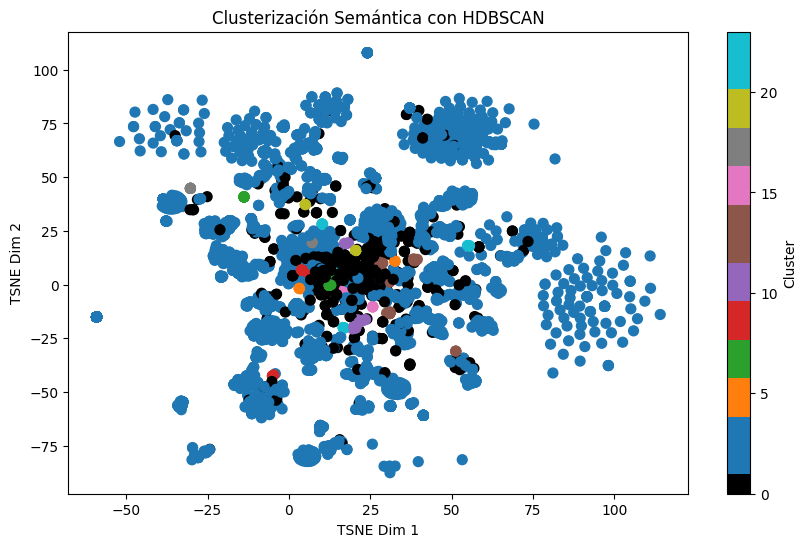

In [18]:
start_time = time.time()

# Generar embeddings
scaler = StandardScaler()
embeddings = model.encode(list(df['clean']))
embeddings = scaler.fit_transform(embeddings)
embeddings.shape

# Clusterizar con DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='cosine')
clusters = dbscan.fit_predict(embeddings)
end_time = time.time()


# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters


# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score}")
print(f"davies_bouldin_score: {db_index}")
print(f"calinski_harabasz_score: {ch_index}")

# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

# Para exploracion de datos
df_clusters_exp_001 = df_clusters.copy()
df_clusters_exp_001.to_csv("df_clusters_exp_001.csv")

### Exp 2: MiniLM + Scaler + HDBSCAN(euclidean)

    Cluster  Cantidad
0        67      1863
1        -1      1597
2        71       182
3        63       112
4        46        86
..      ...       ...
77       44        10
78        6        10
79        8        10
80        1        10
81       31        10

[82 rows x 2 columns]
Tiempo de ejecución: 17.8961 segundos
silhouette_score: 0.8684940338134766
davies_bouldin_score: 0.6797173080957576
calinski_harabasz_score: 916.2747219493363


<ipython-input-19-d3ef91ad0a71>:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


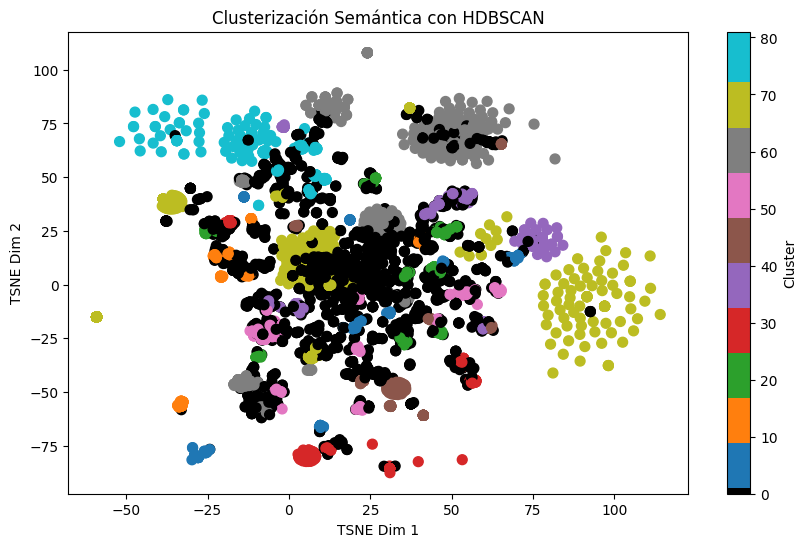

In [19]:
start_time = time.time()

scaler = StandardScaler()
embeddings = model.encode(list(df['clean']))
embeddings = scaler.fit_transform(embeddings)
embeddings.shape

# Paso 2: Clusterización con HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # Tamaño mínimo de un cluster
    min_samples=5,       # Influencia de puntos atípicos
    metric='euclidean'   # Métrica de distancia
)
clusters = clusterer.fit_predict(embeddings)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score}")
print(f"davies_bouldin_score: {db_index}")
print(f"calinski_harabasz_score: {ch_index}")

# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_002 = df_clusters.copy()
df_clusters_exp_002.to_csv("df_clusters_exp_002.csv")

In [ ]:
df_clusters_exp_002[df_clusters_exp_002.Cluster == 46]

,t1txt,clean,Cluster
194,LA CONTAMINACION AMBIENTAL,contaminacion ambiental,46
310,LA CONTAMINACION AMBIENTAL,contaminacion ambiental,46
337,CONTAMINACION AMBIENTAL,contaminacion ambiental,46
339,CONTAMINACION AMBIENTAL,contaminacion ambiental,46
351,CONTAMINACION AMBIENTAL,contaminacion ambiental,46
...,...,...,...
7593,CONTAMINACION AMBIENTAL,contaminacion ambiental,46
7623,CONTAMINACION AMBIENTAL,contaminacion ambiental,46
7721,CONTAMINACION AMBIENTAL,contaminacion ambiental,46
8044,LA CONTAMINACION AMBIENTAL,contaminacion ambiental,46


### Exp 3: MiniLM + Scaler + PCA (80) + HDBSCAN(euclidean)

    Cluster  Cantidad
0        75      1863
1        -1      1539
2        73       182
3        67       112
4        48        86
..      ...       ...
79       33        10
80        8        10
81       44        10
82       10        10
83        1        10

[84 rows x 2 columns]
Tiempo de ejecución: 5.3114 segundos
silhouette_score: 0.4099896252155304
davies_bouldin_score: 0.6635566715795769
calinski_harabasz_score: 970.8418211049509


<ipython-input-20-e3e662629f05>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


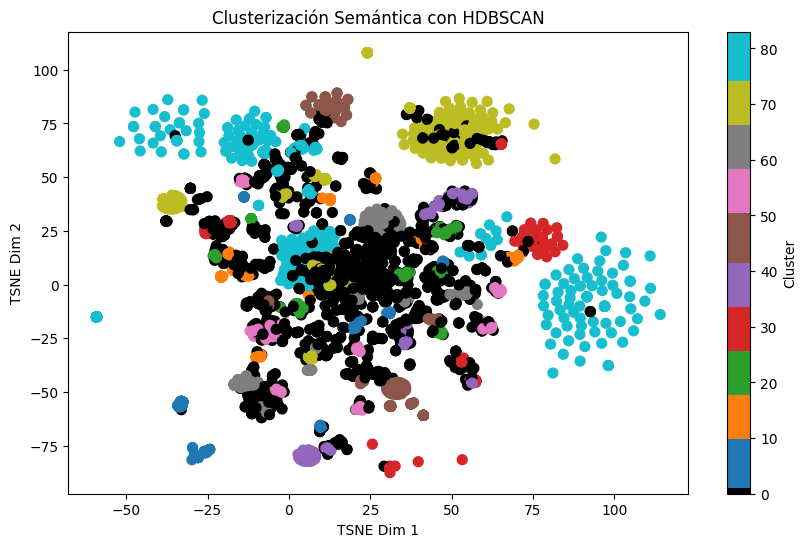

In [20]:
start_time = time.time()
# Reducir a 2 dimensiones
scaler = StandardScaler()
embeddings = model.encode(list(df['clean']))
embeddings = scaler.fit_transform(embeddings)
pca = PCA(n_components=80)
embeddings_ = pca.fit_transform(embeddings)

# Paso 2: Clusterización con HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # Tamaño mínimo de un cluster
    min_samples=5,       # Influencia de puntos atípicos
    metric='euclidean'   # Métrica de distancia
)
clusters = clusterer.fit_predict(embeddings_)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings_) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score}")
print(f"davies_bouldin_score: {db_index}")
print(f"calinski_harabasz_score: {ch_index}")

# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_003 = df_clusters.copy()
df_clusters_exp_003.to_csv("df_clusters_exp_003.csv")

### Exp 4: MiniLM + Scaler + UMAP (80) + HDBSCAN(euclidean)

     Cluster  Cantidad
0          2      1866
1         -1       360
2          9       184
3          1       141
4         77       118
..       ...       ...
119       66        10
120       96        10
121      110        10
122       80        10
123       95        10

[124 rows x 2 columns]
Tiempo de ejecución: 61.1802 segundos
silhouette_score: 0.9351038932800293
davies_bouldin_score: 0.27997250027540643
calinski_harabasz_score: 27802.984072060783


<ipython-input-24-8d94823eacc7>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


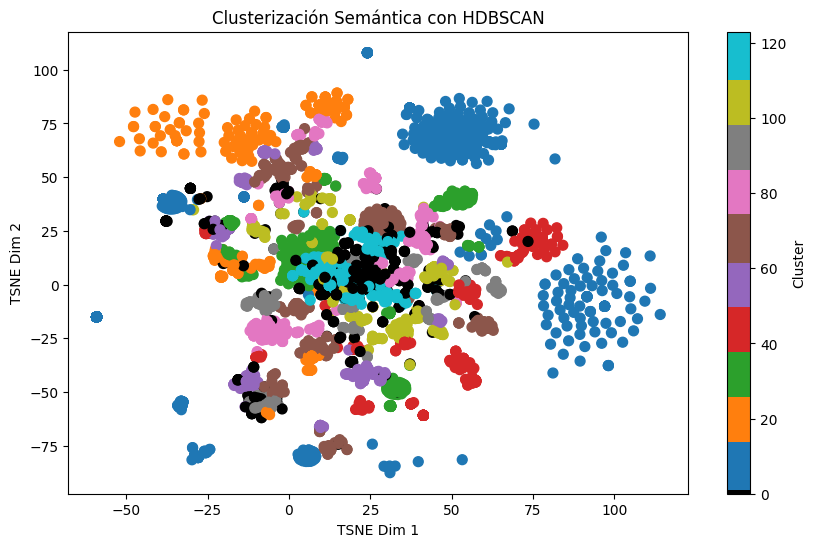

In [24]:
start_time = time.time()

# Reducir a 2 dimensiones
scaler = StandardScaler()
embeddings = model.encode(list(df['clean']))
embeddings = scaler.fit_transform(embeddings)
reducer = umap.UMAP(n_components=80)
embeddings_ = reducer.fit_transform(embeddings)

# Paso 2: Clusterización con HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # Tamaño mínimo de un cluster
    min_samples=5,       # Influencia de puntos atípicos
    metric='euclidean'   # Métrica de distancia
)
clusters = clusterer.fit_predict(embeddings_)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings_) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score}")
print(f"davies_bouldin_score: {db_index}")
print(f"calinski_harabasz_score: {ch_index}")

# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_004 = df_clusters.copy()
# df_clusters_exp_004.to_csv("df_clusters_exp_004.csv")

### Intento de ver como evoluciona para variacion del parametro

In [ ]:


df_temp = df_clusters[df_clusters.Cluster != 26].copy()
scaler = StandardScaler()
embeddings = model.encode(list(df_temp['clean']))
embeddings = scaler.fit_transform(embeddings)
# Listas para almacenar las métricas
sil_scores = []
db_indexes = []
ch_indexes = []
min_cluster_sizes = range(2, 50, 5)  # Valores de min_cluster_size a evaluar

# Iterar sobre diferentes valores de min_cluster_size
for min_cluster_size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,  # Tamaño mínimo de un cluster
        min_samples=1,                     # Influencia de puntos atípicos
        metric='euclidean'                 # Métrica de distancia
    )
    clusters = clusterer.fit_predict(embeddings)

    # Verificar si hay al menos 2 clusters válidos para calcular métricas
    if len(set(clusters)) > 1:
        # Calcular métricas
        sil_score = silhouette_score(embeddings, clusters, metric='cosine')
        db_index = davies_bouldin_score(embeddings, clusters)
        ch_index = calinski_harabasz_score(embeddings, clusters)
    else:
        # Si no hay suficientes clusters, asignar métricas inválidas
        sil_score, db_index, ch_index = None, None, None

    # Guardar métricas en las listas
    sil_scores.append(sil_score)
    db_indexes.append(db_index)
    ch_indexes.append(ch_index)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Silhouette Score
plt.plot(min_cluster_sizes, sil_scores, marker='o', label='Silhouette Score')

# Davies-Bouldin Index
plt.plot(min_cluster_sizes, db_indexes, marker='s', label='Davies-Bouldin Index')

# Calinski-Harabasz Index
plt.plot(min_cluster_sizes, ch_indexes, marker='^', label='Calinski-Harabasz Index')

# Configurar gráfico
plt.title('Evolución de Métricas de Clusterización')
plt.xlabel('min_cluster_size')
plt.ylabel('Valor de Métrica')
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

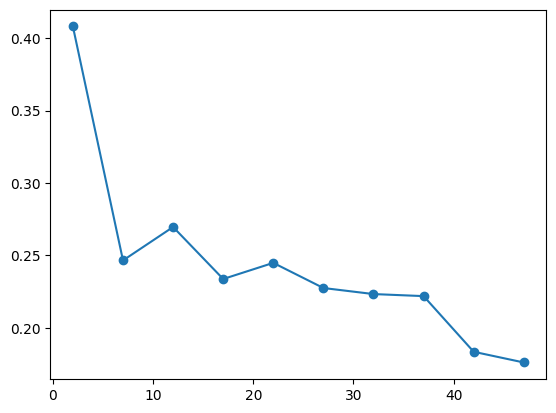

In [ ]:
plt.plot(min_cluster_sizes, sil_scores, marker='o', label='Silhouette Score')
plt.show()

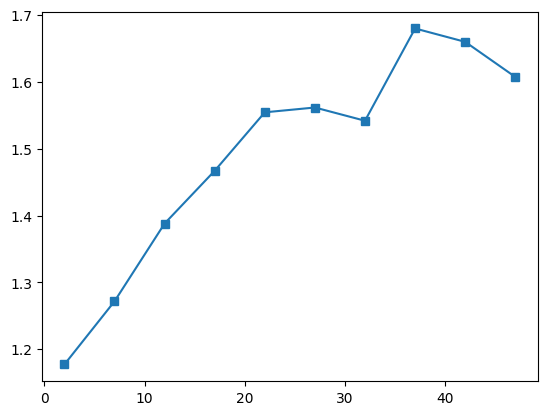

In [ ]:
plt.plot(min_cluster_sizes, db_indexes, marker='s', label='Davies-Bouldin Index')
plt.show()

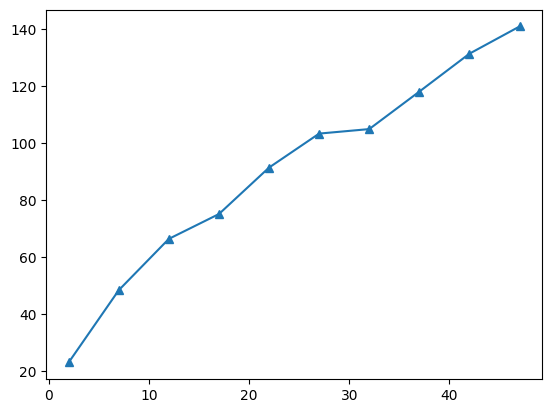

In [ ]:
plt.plot(min_cluster_sizes, ch_indexes, marker='^', label='Calinski-Harabasz Index')
plt.show()

In [ ]:
df_clusters = df_temp[df_clusters.Cluster != -1].copy()

In [ ]:
df_clusters = df_temp[df_clusters.Cluster != -1].copy()
df_clusters['Cluster'] = clusters
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

print(cluster_counts)

    Cluster  Cantidad
0        -1      1863
1        17       311
2        16       212
3         6       172
4        13       165
5         3       136
6         2       112
7        12       103
8         5       100
9        14        85
10        1        80
11        4        71
12       11        68
13        7        61
14       10        58
15        9        58
16       15        56
17        8        49
18        0        49


In [ ]:
embeddings.shape

(1946, 384)

### Grafico de la clusterización semantica sin outliers

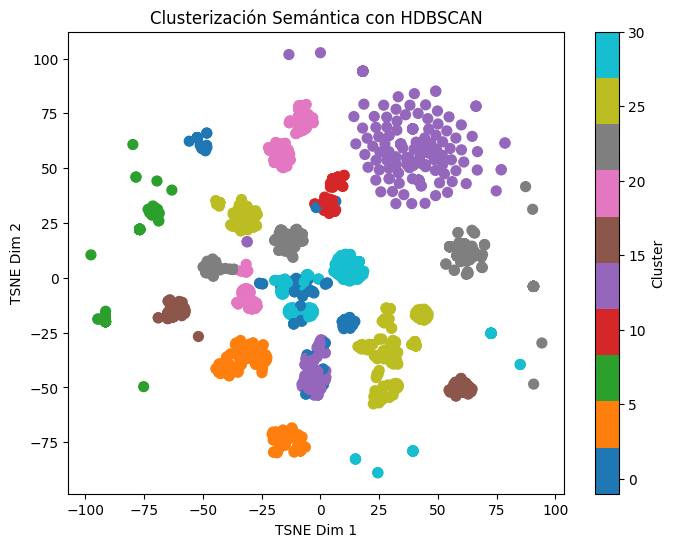

In [ ]:
scaler = StandardScaler()
embeddings = model.encode(list(df_clusters['clean']))
embeddings = scaler.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df_clusters['Cluster'], cmap='tab10', s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

### Exp 5: MiniLM + Scaler + UMAP (80) + OPTICS(cosine)

     Cluster  Cantidad
0         -1      1639
1        385        40
2        357        37
3        340        34
4        257        34
..       ...       ...
394      131         5
395      110         5
396       44         5
397      164         5
398      165         5

[399 rows x 2 columns]
Tiempo de ejecución: 81.4437 segundos
silhouette_score: 0.8044
davies_bouldin_score: 0.5136
calinski_harabasz_score: 97749.2850


<ipython-input-21-357ac419dcac>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


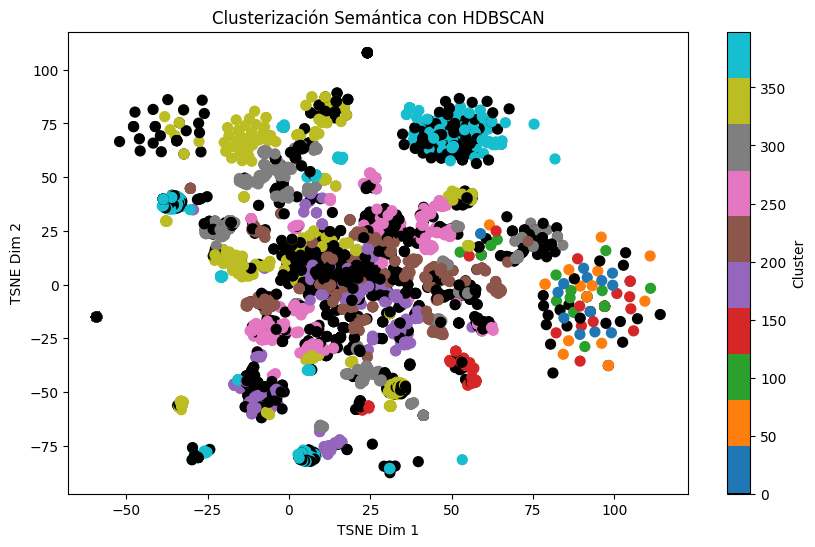

In [21]:
start_time = time.time()

scaler = StandardScaler()
embeddings = model.encode(list(df['clean']))
embeddings = scaler.fit_transform(embeddings)
reducer = umap.UMAP(n_components=80)
embeddings_ = reducer.fit_transform(embeddings)

optics = OPTICS(min_samples=5, metric='cosine')
clusters = optics.fit_predict(embeddings_)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings_) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score:.4f}")
print(f"davies_bouldin_score: {db_index:.4f}")
print(f"calinski_harabasz_score: {ch_index:.4f}")


# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_005 = df_clusters.copy()
df_clusters_exp_005.to_csv("df_clusters_exp_005.csv")

In [ ]:
cluster_counts.head(20)

,Cluster,Cantidad
0,-1,1598
1,340,50
2,298,48
3,403,40
4,353,40
5,383,37
6,277,34
7,252,33
8,285,32
9,265,26


In [ ]:
df_clusters[df_clusters.Cluster == -1]

,t1txt,clean,Cluster
7,EL FEMINICIDIO,feminicidio,-1
25,FALTA DE RESPETO A LA MUJER,falta respeto mujer,-1
28,LA INMORALIDAD DE LOS POLITICOS,inmoralidad politico,-1
31,INCAPACIDAD DE LOS TRABAJADORES DEL ESTADO,incapacidad trabajadores,-1
32,DROGADICCION,drogadiccion,-1
...,...,...,...
8269,FALTA DE ACCESIBILIDAD A LOS CASERIOS ALEJADOS,falta accesibilidad caserios alejados,-1
8277,NO SABE,sabe,-1
8285,MIGRACION VENEZOLANA,migracion venezolana,-1
8287,FALTA E SEGVIOS BASICOS COMO AGUA DESAGUE,falta segvios basicos agua desague,-1


### Exp 6: MiniLM + UMAP (80) + OPTICS(cosine)

     Cluster  Cantidad
0         -1      1470
1        361        37
2        288        37
3        357        32
4        210        29
..       ...       ...
400      151         5
401        7         5
402      324         5
403      367         5
404      328         5

[405 rows x 2 columns]
Tiempo de ejecución: 89.3820 segundos
silhouette_score: 0.8210
davies_bouldin_score: 0.5061
calinski_harabasz_score: 111009.7663


<ipython-input-22-b9bae8cdd88f>:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


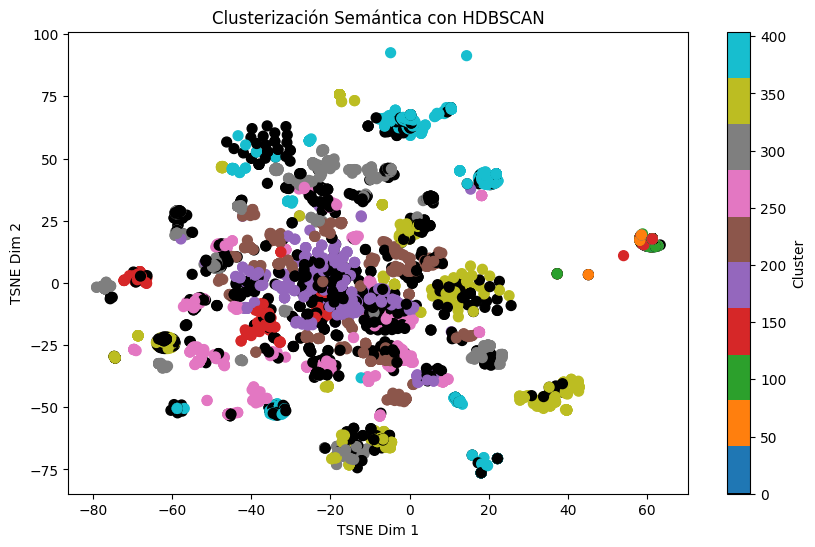

In [22]:
start_time = time.time()

# Generar embeddings
# scaler = StandardScaler()
embeddings = model.encode(list(df['clean']))
# embeddings = scaler.fit_transform(embeddings)
reducer = umap.UMAP(n_components=80)
embeddings_ = reducer.fit_transform(embeddings)

optics = OPTICS(min_samples=5, metric='cosine')
clusters = optics.fit_predict(embeddings_)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings_) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score:.4f}")
print(f"davies_bouldin_score: {db_index:.4f}")
print(f"calinski_harabasz_score: {ch_index:.4f}")

# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_006 = df_clusters.copy()
df_clusters_exp_006.to_csv("df_clusters_exp_006.csv")

# Pruebas con el encoder fastText

In [9]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz

--2024-12-09 06:35:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.15, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4500107671 (4.2G) [application/octet-stream]
Saving to: ‘cc.es.300.bin.gz’

cc.es.300.bin.gz    100%[===================>]   4.19G   158MB/s    in 47s     

2024-12-09 06:36:05 (91.1 MB/s) - ‘cc.es.300.bin.gz’ saved [4500107671/4500107671]



In [12]:
import fasttext.util
fasttext.util.download_model('es', if_exists='ignore')  # Descargar modelo español
ft = fasttext.load_model('cc.es.300.bin')

# Codificar una frase corta
vector = ft.get_sentence_vector("Excelente producto")

In [13]:
df = pd.read_csv("2019_info.csv", index_col=0)
# respuestas = list(df.t1txt)
df['clean'] = df.t1txt.apply(preprocess_string)


### Exp7: FastText + HDBSCAN(euclidean)

     Cluster  Cantidad
0          3      1915
1         -1      1661
2         20       182
3         93       123
4         45       104
..       ...       ...
113        2         6
114      113         6
115       40         6
116       37         5
117       17         5

[118 rows x 2 columns]
Tiempo de ejecución: 13.0144 segundos
silhouette_score: 0.9235
davies_bouldin_score: 0.6256
calinski_harabasz_score: 1823.5566


<ipython-input-14-707e9bc7fbc0>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


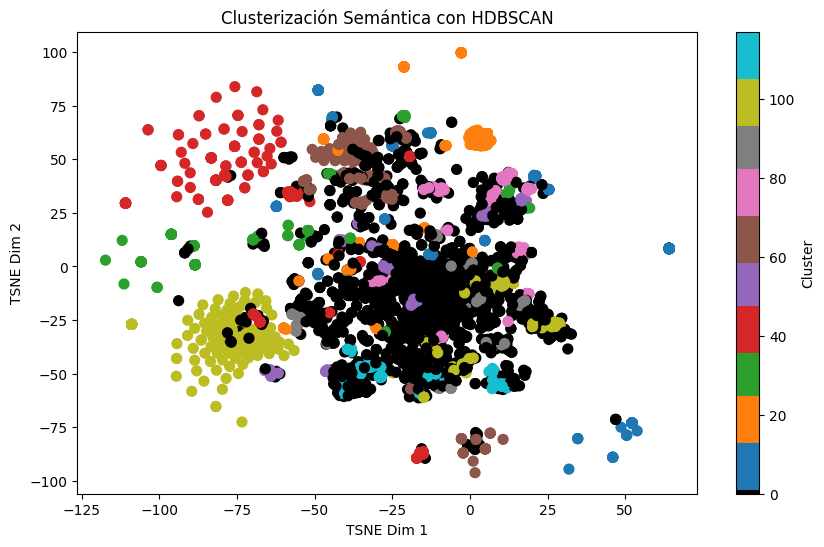

In [14]:
start_time = time.time()
# Generar embeddings
# scaler = StandardScaler()
embeddings = np.array([ft.get_sentence_vector(frase) for frase in list(df['clean'])])
# embeddings = scaler.fit_transform(embeddings)

# Paso 2: Clusterización con HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,  # Tamaño mínimo de un cluster
    min_samples=5,       # Influencia de puntos atípicos
    metric='euclidean'   # Métrica de distancia
)
clusters = clusterer.fit_predict(embeddings)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score:.4f}")
print(f"davies_bouldin_score: {db_index:.4f}")
print(f"calinski_harabasz_score: {ch_index:.4f}")

# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_007 = df_clusters.copy()
df_clusters_exp_007.to_csv("df_clusters_exp_007.csv")

## EXP8: FastText + OPTICS(cosine)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


     Cluster  Cantidad
0          0      1915
1         -1      1534
2        100       182
3          3       122
4         97       104
..       ...       ...
148       71         5
149      133         5
150       80         5
151       74         5
152      131         5

[153 rows x 2 columns]
Tiempo de ejecución: 109.8787 segundos
silhouette_score: 0.9197
davies_bouldin_score: 0.7018
calinski_harabasz_score: 1205.4149


<ipython-input-15-29c5e48e1b80>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


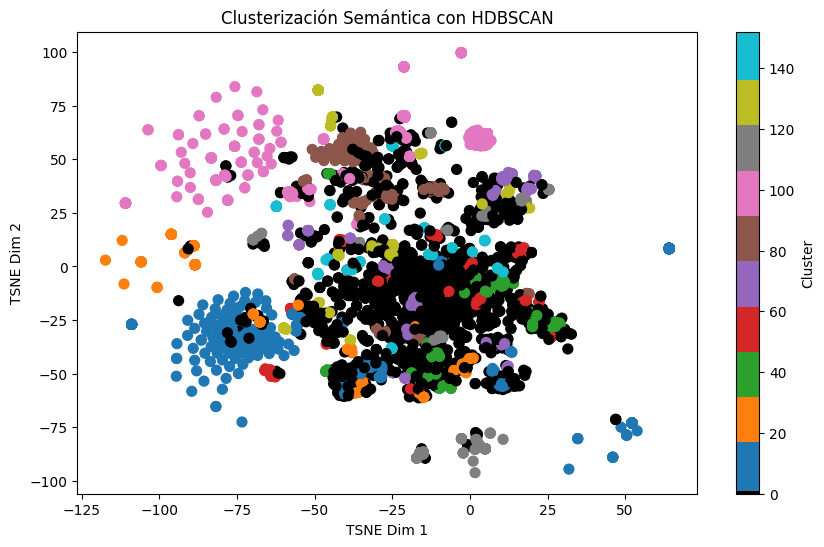

In [15]:
start_time = time.time()
embeddings = np.array([ft.get_sentence_vector(frase) for frase in list(df['clean'])])
optics = OPTICS(min_samples=5, metric='cosine')
clusters = optics.fit_predict(embeddings)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score:.4f}")
print(f"davies_bouldin_score: {db_index:.4f}")
print(f"calinski_harabasz_score: {ch_index:.4f}")


# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_008 = df_clusters.copy()
df_clusters_exp_008.to_csv("df_clusters_exp_008.csv")

## Exp 9: FastText + Scaler + PCA + OPTICS(cosine)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:1083: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


     Cluster  Cantidad
0          0      1915
1         -1      1467
2         92       182
3         37       123
4         88       106
..       ...       ...
148      133         5
149        4         5
150       12         5
151      148         5
152        3         5

[153 rows x 2 columns]
Tiempo de ejecución: 39.2421 segundos
silhouette_score: 0.9130
davies_bouldin_score: 0.7183
calinski_harabasz_score: 1011.0829


<ipython-input-16-9addb663c969>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


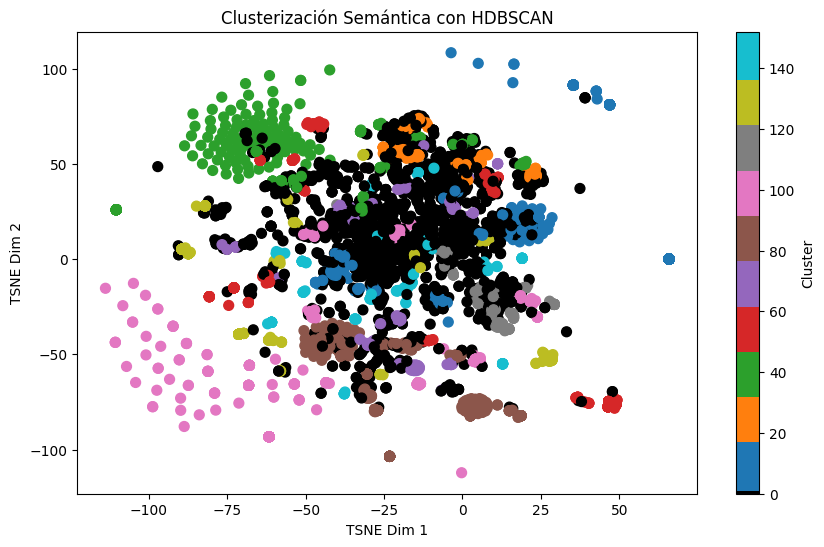

In [16]:
start_time = time.time()
# Reducir a 2 dimensiones
scaler = StandardScaler()
embeddings = np.array([ft.get_sentence_vector(frase) for frase in list(df['clean'])])
embeddings = scaler.fit_transform(embeddings)
pca = PCA(n_components=80)
embeddings_ = pca.fit_transform(embeddings)

optics = OPTICS(min_samples=5, metric='cosine')
clusters = optics.fit_predict(embeddings_)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)

filtered_embeddings = [embedding for i, embedding in enumerate(embeddings_) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score:.4f}")
print(f"davies_bouldin_score: {db_index:.4f}")
print(f"calinski_harabasz_score: {ch_index:.4f}")

# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_009 = df_clusters.copy()
df_clusters_exp_009.to_csv("df_clusters_exp_009.csv")

## Exp10: FastText + Scaler + UMAP(cosine) + OPTIC(cosine)

     Cluster  Cantidad
0         -1      1264
1        252        39
2        358        34
3        316        34
4        305        31
..       ...       ...
406      174         5
407      335         5
408      225         5
409       62         5
410      160         5

[411 rows x 2 columns]
Tiempo de ejecución: 77.4507 segundos
silhouette_score: 0.8277
davies_bouldin_score: 0.5061
calinski_harabasz_score: 80036.1794


<ipython-input-17-199b0f15d7c3>:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


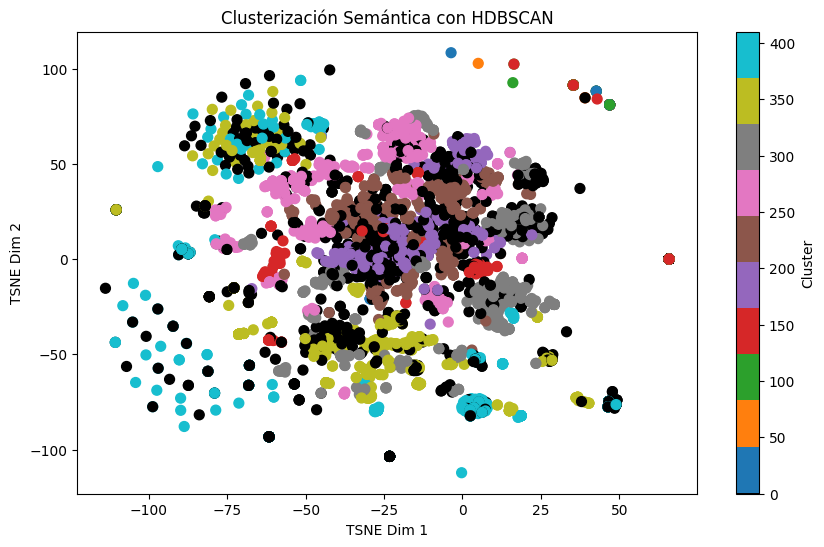

In [17]:
start_time = time.time()

# Reducir a 2 dimensiones
scaler = StandardScaler()
embeddings = np.array([ft.get_sentence_vector(frase) for frase in list(df['clean'])])
embeddings = scaler.fit_transform(embeddings)
reducer = umap.UMAP(n_components=80)
embeddings_ = reducer.fit_transform(embeddings)


optics = OPTICS(min_samples=5, metric='cosine')
clusters = optics.fit_predict(embeddings_)
end_time = time.time()

# Paso 3: Combinar respuestas con clusters en un DataFrame
df_clusters = df.copy()
df_clusters['Cluster'] = clusters

# Contar el número de respuestas en cada cluster
cluster_counts = df_clusters['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Cantidad']

# Mostrar la tabla de conteos
print(cluster_counts)


filtered_embeddings = [embedding for i, embedding in enumerate(embeddings_) if clusters[i] != -1]
filtered_clusters = [cluster for cluster in clusters if cluster != -1]
sil_score = silhouette_score(filtered_embeddings, filtered_clusters, metric='cosine')
db_index = davies_bouldin_score(filtered_embeddings, filtered_clusters)
ch_index = calinski_harabasz_score(filtered_embeddings, filtered_clusters)
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.4f} segundos")
print(f"silhouette_score: {sil_score:.4f}")
print(f"davies_bouldin_score: {db_index:.4f}")
print(f"calinski_harabasz_score: {ch_index:.4f}")

# Paso 4: Visualización con t-SNE
# Reducir dimensionalidad para visualización
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Graficar los clusters

unique_clusters = np.unique(clusters)
num_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
colormap = plt.cm.get_cmap('tab10', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
colors.insert(0, 'black')  # Negro para el ruido

# Crear un mapa de colores final
cmap = ListedColormap(colors)

# Asignar índices de color: -1 se mapea a 0 (negro), los demás a 1, 2, ...
color_indices = np.array([0 if cluster == -1 else cluster + 1 for cluster in clusters])

# Graficar los puntos
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=color_indices, cmap=cmap, s=50)
plt.title("Clusterización Semántica con HDBSCAN")
plt.xlabel("TSNE Dim 1")
plt.ylabel("TSNE Dim 2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_exp_010 = df_clusters.copy()
df_clusters_exp_010.to_csv("df_clusters_exp_010.csv")